## Predicting the English Premier League table using statistical modelling.

This project attempts to determine whether goal scoring in the premier league can be modelled by a poisson process. A simple Poisson model is a good starting point to model the number of goals scored in a match in a 90-min game. Later, we will use this to simulate an entire season using on the data from 2005-2020 seasons. 

The data for this project is scraped from [football-data.co.uk](https://www.football-data.co.uk) which contains information for each game since 1993/94 season.

In [1]:
import sys
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import poisson
from tqdm.notebook import tqdm

In [2]:
def display_all(df):
    with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
        display(df)

In [55]:
epl = pd.read_csv('data/epl_05-20.csv')
epl.shape

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(5701, 140)

Here is a snapshot of the data

In [56]:
epl.tail(3)

,Div,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
5698,E0,1920,26/07/2020,Newcastle,Liverpool,1.0,3.0,A,1.0,1.0,...,2.40,1.0,1.94,1.96,1.95,1.97,2.03,2.00,1.95,1.92
5699,E0,1920,26/07/2020,Southampton,Sheffield United,3.0,1.0,H,0.0,1.0,...,2.01,-0.5,1.97,1.93,2.00,1.93,2.03,1.96,1.98,1.89
5700,E0,1920,26/07/2020,West Ham,Aston Villa,1.0,1.0,D,0.0,0.0,...,2.03,0.0,1.93,1.97,1.95,1.98,1.99,2.00,1.93,1.95


In [57]:
epl_full = epl.copy(deep=True)

For this project we only need 5 columns starting from the `Date` field. Therefore, let's get rid of the unwanted columns and rename them so that is is easier to index these columns.

In [58]:
# removing unncessary cols
epl = epl.iloc[:, 1:7]

In [59]:
# rename cols
epl.columns = [i.lower() for i in epl]
epl.rename(columns={'fthg':'homegoals', 'ftag':'awaygoals'}, inplace=True)

Let's have a look at the average number of home and away goals scored in each game.

In [7]:
# avg home vs away goals
epl.mean()[1:]

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_1051/2645880612.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  epl.mean()[1:]


homegoals    1.537544
awaygoals    1.147544
dtype: float64

Well, this result should be intuitive to anyone who follows sports like Soccer, American football, Basketball, etc. as the team which plays at home is considered to have an advantage mainly due to the players familiarity and comfort with the environment and their fan's presence. 

Let's try to compare the actual number goals scored in a game to the goals calculated by the poisson process.

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_1051/856969210.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  poisson_pred = np.column_stack([[poisson.pmf(i, epl.mean()[1:][j]) for i in range(9)] for j in range(2)])
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other argumen

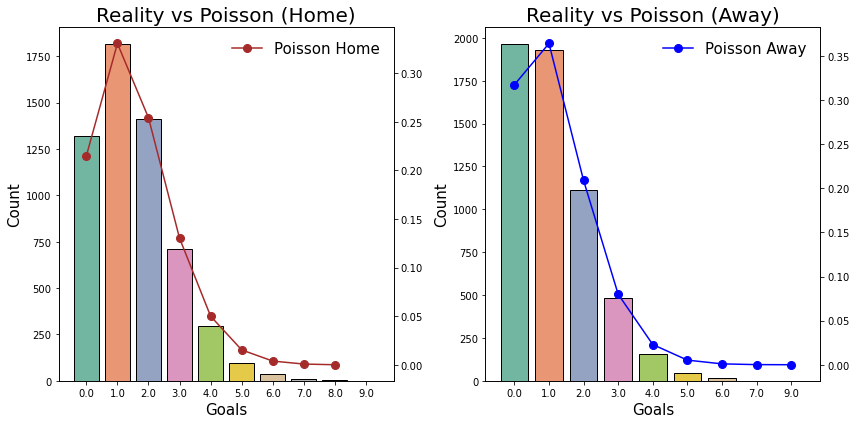

In [124]:
poisson_pred = np.column_stack([[poisson.pmf(i, epl.mean()[1:][j]) for i in range(9)] for j in range(2)])

fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.countplot(epl.homegoals, ax=ax[0], palette='Set2', edgecolor='black')
ax1 = ax[0].twinx()
ax1.plot(poisson_pred[:, 0], marker='o', linestyle='-', markersize=8, label='Poisson Home', color='brown')
ax[0].set_xlabel('Goals', fontsize=15);
ax[0].set_ylabel('Count', fontsize=15);
plt.legend(frameon=False, fontsize=15);
ax[0].set_title('Reality vs Poisson (Home)', fontsize=20)

sns.countplot(epl.awaygoals, ax=ax[1], palette='Set2', edgecolor='black')
ax2 = ax[1].twinx()
ax2.plot(poisson_pred[:, 1], marker='o', linestyle='-', markersize=8, label='Poisson Away', color='blue')
ax[1].set_xlabel('Goals', fontsize=15);
ax[1].set_ylabel('Count', fontsize=15);
plt.legend(frameon=False, fontsize=15);
ax[1].set_title('Reality vs Poisson (Away)', fontsize=20);

plt.tight_layout();

plt.savefig('assets/reality-vs-poisson-fig1.jpeg', bbox_inches='tight')

The poisson model fits the distribution very well, as shown in the figures above. Hopefully, we'll be able to adapt this method to simulate individual matches throughout the course of a season.

In [9]:
def _get_team(team):
    return re.findall('\[(.*?)\]', team)[0]


def get_stats(model):
    summary_df = model.summary()
    results_html = summary_df.tables[1].as_html()
    
    summary_df = pd.read_html(results_html, header=0)[0]
    summary_df.columns = ['team', 'coef', 'std_err', 'z', 'p-val', '0.025', '0.975']
    summary_df.reset_index(drop=True, inplace=True)
    
    summary_df['rate'] = np.exp(summary_df.coef)
    summary_df.team = summary_df.team.apply(_get_team)
    
    return summary_df[['team', 'rate']]

We will now create poisson regression models and get the regression coefficients as each team's home and away scoring rates. Since, by default, statsmodels uses the team that comes first alphabetically as the reference group, we will replace the y-intercept term with 0. 

In [10]:
home = smf.glm(formula="homegoals ~ 0 + hometeam", data=epl, 
                        family=sm.families.Poisson()).fit()
home.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              homegoals   No. Observations:                 5700
Model:                            GLM   Df Residuals:                     5661
Model Family:                 Poisson   Df Model:                           38
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8746.5
Date:                Thu, 25 Nov 2021   Deviance:                       6561.9
Time:                        10:39:35   Pearson chi2:                 5.72e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09657
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hometeam[Arsenal]              0.7527      0.041     18.515      0.000       0.673       0.832
hometeam[Aston Villa]          0.1874      0.060      3.108      0.002       0.069       0.306
hometeam[Birmingham]           0.1352      0.107      1.261      0.207      -0.075       0.345
hometeam[Blackburn]            0.3354      0.073      4.574      0.000       0.192       0.479
hometeam[Blackpool]            0.4568      0.183      2.502      0.012       0.099       0.815
hometeam[Bolton]               0.3137      0.074      4.231      0.000       0.168       0.459
hometeam[Bournemouth]          0.3588      0.086      4.184      0.000       0.191       0.527
hometeam[Brighton]             0.1001      0.126      0.794      0.427      -0.147       0.347
hometeam[Burnley]              0.1236      0.088      1.404      0.160      -0.049       0.296
hometeam[Cardiff]              0.0760      0.156      0.487      0.627      -0.230       0.382
hometeam[Charlton]             0.0760      0.156      0.487      0.627      -0.230       0.382
hometeam[Chelsea]              0.7560      0.041     18.627      0.000       0.676       0.836
hometeam[Crystal Palace]       0.0864      0.083      1.040      0.298      -0.076       0.249
hometeam[Derby]               -0.4595      0.289     -1.592      0.111      -1.025       0.106
hometeam[Everton]              0.5024      0.046     10.903      0.000       0.412       0.593
hometeam[Fulham]               0.3365      0.061      5.488      0.000       0.216       0.457
hometeam[Huddersfield]        -0.3795      0.196     -1.935      0.053      -0.764       0.005
hometeam[Hull]                 0.1190      0.097      1.230      0.219      -0.071       0.308
hometeam[Leicester]            0.4456      0.075      5.945      0.000       0.299       0.592
hometeam[Liverpool]            0.7527      0.041     18.515      0.000       0.673       0.832
hometeam[Man City]             0.8105      0.039     20.521      0.000       0.733       0.888
hometeam[Man United]           0.7527      0.041     18.515      0.000       0.673       0.832
hometeam[Middlesbrough]        0.2336      0.091      2.559      0.010       0.055       0.413
hometeam[Newcastle]            0.3196      0.054      5.892      0.000       0.213       0.426
hometeam[Norwich]              0.1911      0.093      2.049      0.040       0.008       0.374
hometeam[Portsmouth]           0.2252      0.092      2.457      0.014       0.046       0.405
hometeam[QPR]                  0.0513      0.129      0.397      0.691      -0.202       0.304
hometeam[Reading]              0.2196      0.119      1.851      0.064      -0.013       0.452
hometeam[Sheffield United]     0.2336      0.144      1.619      0.106      -0.049       0.517
hometeam[Southampton]          0.3652      

Similarly for away goals

In [11]:
away = smf.glm(formula="awaygoals ~ 0 + awayteam", data=epl, 
                        family=sm.families.Poisson()).fit()
away.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              awaygoals   No. Observations:                 5700
Model:                            GLM   Df Residuals:                     5661
Model Family:                 Poisson   Df Model:                           38
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7854.0
Date:                Thu, 25 Nov 2021   Deviance:                       6783.8
Time:                        10:39:35   Pearson chi2:                 5.94e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08115
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
awayteam[Arsenal]              0.4634      0.047      9.863      0.000       0.371       0.555
awayteam[Aston Villa]          0.1197      0.062      1.919      0.055      -0.003       0.242
awayteam[Birmingham]          -0.2036      0.127     -1.603      0.109      -0.453       0.045
awayteam[Blackburn]            0.0655      0.084      0.780      0.435      -0.099       0.230
awayteam[Blackpool]            0.2744      0.200      1.372      0.170      -0.118       0.666
awayteam[Bolton]              -0.0152      0.087     -0.173      0.862      -0.186       0.156
awayteam[Bournemouth]          0.1001      0.098      1.026      0.305      -0.091       0.291
awayteam[Brighton]            -0.2364      0.149     -1.586      0.113      -0.529       0.056
awayteam[Burnley]             -0.0918      0.098     -0.936      0.349      -0.284       0.100
awayteam[Cardiff]             -0.4187      0.200     -2.094      0.036      -0.811      -0.027
awayteam[Charlton]            -0.1112      0.171     -0.649      0.517      -0.447       0.225
awayteam[Chelsea]              0.4700      0.047     10.037      0.000       0.378       0.562
awayteam[Crystal Palace]       0.1269      0.081      1.560      0.119      -0.033       0.286
awayteam[Derby]               -0.8650      0.354     -2.447      0.014      -1.558      -0.172
awayteam[Everton]              0.0937      0.057      1.658      0.097      -0.017       0.204
awayteam[Fulham]              -0.1908      0.080     -2.390      0.017      -0.347      -0.034
awayteam[Huddersfield]        -0.4595      0.204     -2.251      0.024      -0.860      -0.059
awayteam[Hull]                -0.2498      0.116     -2.149      0.032      -0.478      -0.022
awayteam[Leicester]            0.3264      0.080      4.103      0.000       0.170       0.482
awayteam[Liverpool]            0.4411      0.048      9.284      0.000       0.348       0.534
awayteam[Man City]             0.4895      0.046     10.557      0.000       0.399       0.580
awayteam[Man United]           0.4895      0.046     10.557      0.000       0.399       0.580
awayteam[Middlesbrough]       -0.3054      0.120     -2.555      0.011      -0.540      -0.071
awayteam[Newcastle]           -0.0583      0.066     -0.891      0.373      -0.187       0.070
awayteam[Norwich]             -0.2912      0.119     -2.454      0.014      -0.524      -0.059
awayteam[Portsmouth]          -0.1350      0.110     -1.230      0.219      -0.350       0.080
awayteam[QPR]                 -0.0357      0.135     -0.265      0.791      -0.300       0.229
awayteam[Reading]              0.1313      0.124      1.059      0.290      -0.112       0.374
awayteam[Sheffield United]    -0.5021      0.209     -2.408      0.016      -0.911      -0.093
awayteam[Southampton]          0.1178      

Now that we have the home and away scoring rates for each team let's prepare the data for the simulation. 

In [12]:
home_rate, away_rate = get_stats(home), get_stats(away)

home_rate['key'] = 1
away_rate['key'] = 1

We first combine the two dataframes such that every club plays with every other team twice (home and away). This results in a total of 380 rows, representing the 380 matchups of the season.

Since we used the data from seasons 2005-2020, there are some teams which are relegated and therefore currently not in the EPL. It makes sense to exclude these clubs and include only those which have qualified for the next season.

In [13]:
xG = home_rate.merge(away_rate, how='outer', suffixes=('_home', '_away'), on='key').drop('key', axis=1)
xG = xG[xG.team_home != xG.team_away].reset_index(drop=True)

In [14]:
xG.head(2)

,team_home,rate_home,team_away,rate_away
0,Arsenal,2.122724,Aston Villa,1.127159
1,Arsenal,2.122724,Birmingham,0.815789


In [15]:
qualified_teams = ['Arsenal',
                    'Aston Villa',
                    'Brighton',
                    'Burnley',
                    'Chelsea',
                    'Crystal Palace',
                    'Everton',
                    'Fulham',
                    'Leeds United',
                    'Leicester',
                    'Liverpool',
                    'Man City',
                    'Man United',
                    'Newcastle',
                    'Sheffield United',
                    'Southampton',
                    'Tottenham',
                    'West Brom',
                    'West Ham',
                    'Wolves']

xG = xG[(xG.team_home.isin(qualified_teams)) & (xG.team_away.isin(qualified_teams))]
xG.reset_index(drop=True, inplace=True)
xG

,team_home,rate_home,team_away,rate_away
0,Arsenal,2.122724,Aston Villa,1.127159
1,Arsenal,2.122724,Brighton,0.789465
2,Arsenal,2.122724,Burnley,0.912288
3,Arsenal,2.122724,Chelsea,1.599994
4,Arsenal,2.122724,Crystal Palace,1.135303
...,...,...,...,...
337,Wolves,1.231583,Sheffield United,0.605258
338,Wolves,1.231583,Southampton,1.125019
339,Wolves,1.231583,Tottenham,1.480678
340,Wolves,1.231583,West Brom,0.863121


In [16]:
342 * 10_000

3420000

We would like to simulate the results 10,000 times, hence we dulplicate the above table 10,000 times, and create a new table with 3420000 (342 x 10,000) rows where each 342 row subset is the result of 1 simulation. We feed in the scoring rates calculated earlier to the poisson distribution to generate the number of goals scored for every home and away team in every row of the table. 

In addition, the number of points for every match outcome based on the team’s number of goals scored are also calculated, as a side gets 3 points if it scores more than its opponent, 1 point if it’s a draw, and 0 points if the opposing roster has more goals.

In [17]:
n_sim = 10_000
sim_xG = pd.concat([xG]*n_sim)

In [43]:
def _get_scores(t_home, t_away):
    rate_home = xG[xG.team_home == t_home]['rate_home'].unique()[0]
    rate_away = xG[xG.team_away == t_away]['rate_away'].unique()[0]
    
    score_home, score_away = poisson.rvs(rate_home), poisson.rvs(rate_away)
    return score_home, score_away

In [44]:
sim_xG['score'] = sim_xG.apply(lambda x: _get_scores(x['team_home'], x['team_away']), axis=1) # this takes a while to run

sim_xG[['sim_home', 'sim_away']] = pd.DataFrame(sim_xG['score'].tolist(), index=sim_xG.index)
sim_xG.drop('score', axis=1, inplace=True)

sim_xG['home_pts'] = np.where(sim_xG.sim_home > sim_xG.sim_away, 3, np.where(sim_xG.sim_home == sim_xG.sim_away, 1, 0))
sim_xG['away_pts'] = np.where(sim_xG.sim_home > sim_xG.sim_away, 0, np.where(sim_xG.sim_home == sim_xG.sim_away, 1, 3))


Here's a look at the first few rows of the table. The columns `sim_home` and `sim_away` indicate our simulate match outcome for each matchup, as they are the number of goals scored for each club randomly generated using their scoring rates. `home_pts` and `away_pts` columns show the final points of the match. For example, consider the second row, Arsenal vs Brighton, Arsenal on their home pitch beats Brighton 2-1 and is therefore awarded 3 points for the win whereas Brighton gets no points for their loss.

In [3]:
sim_xG.head(3)

,team_home,rate_home,team_away,rate_away,sim_home,sim_away,home_pts,away_pts
0,Arsenal,2.122724,Aston Villa,1.127159,1,0,3,0
1,Arsenal,2.122724,Brighton,0.789465,2,1,3,0
2,Arsenal,2.122724,Burnley,0.912288,4,1,3,0


In [45]:
def sim_season(num):
    frow = 342 * num - 342
    lrow = 342 * num
    sim_table = sim_xG.iloc[frow:lrow, :]
    
    home_stats = sim_table.groupby('team_home')[['home_pts', 'sim_home', 'sim_away']].sum()
    away_stats = sim_table.groupby('team_away')[['away_pts', 'sim_away', 'sim_home']].sum()
    
    final_ranks = pd.merge(home_stats, away_stats, left_index=True, right_index=True, suffixes=('_x1', '_x2'))
    final_ranks['final_pts'] = final_ranks['home_pts'] + final_ranks['away_pts']
    final_ranks['gd'] = (final_ranks['sim_home_x1'] - final_ranks['sim_away_x1']) + (final_ranks['sim_away_x2'] - final_ranks['sim_home_x2'])
    final_ranks['sim'] = num
    final_ranks['rank'] = final_ranks[['final_pts', 'gd']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)
    final_ranks.reset_index(inplace=True)
    final_ranks.rename(columns={'team_home': 'team'}, inplace=True)
    final_ranks.sort_values(by='rank', inplace=True)
    final_ranks.reset_index(drop=True, inplace=True)
    
    return final_ranks[['team', 'final_pts', 'gd', 'sim', 'rank']]

Let's have a look at one of the simulation

In [46]:
sim_season(7)

,team,final_pts,gd,sim,rank
0,Man United,67,22,7,1
1,Arsenal,67,18,7,2
2,Chelsea,67,16,7,3
3,Leicester,61,14,7,4
4,Man City,59,29,7,5
5,Liverpool,59,21,7,6
6,Tottenham,53,8,7,7
7,Newcastle,50,-4,7,8
8,Southampton,46,7,7,9
9,Fulham,46,-7,7,10


We're now interested in obtaining the result for each one of our 10,000 simulations. We combine all the results in a single dataframe. The simulation group of each row is denoted by the `sim` column.

In [47]:
epl_sim = pd.DataFrame()

values = range(1, n_sim+1)
with tqdm(total=len(values), file=sys.stdout) as pbar:
    for i in values:
        pbar.set_description(f"processing simulation: {i}")
        pbar.update()

        epl_sim = epl_sim.append(sim_season(i))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
epl_sim.head()

,team,final_pts,gd,sim,rank
0,Arsenal,68,23,1,1
1,Man United,65,23,1,2
2,Tottenham,64,25,1,3
3,Man City,63,22,1,4
4,Liverpool,58,21,1,5


Let's take a look each team's chances of finishing at each position.

In [49]:
epl_sim.groupby('team')['rank'].value_counts(normalize=True).unstack().fillna(0)

rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
team,,,,,,,,,,,,,,,,,,,
Arsenal,0.1615,0.1593,0.1540,0.1331,0.1140,0.0852,0.0611,0.0438,0.0321,0.0214,0.0118,0.0080,0.0048,0.0046,0.0026,0.0017,0.0005,0.0004,0.0001
Aston Villa,0.0012,0.0044,0.0063,0.0143,0.0219,0.0328,0.0524,0.0623,0.0707,0.0758,0.0817,0.0841,0.0857,0.0812,0.0814,0.0708,0.0686,0.0620,0.0424
Brighton,0.0001,0.0002,0.0008,0.0023,0.0029,0.0067,0.0109,0.0187,0.0250,0.0361,0.0465,0.0519,0.0645,0.0760,0.0932,0.1166,0.1340,0.1531,0.1605
Burnley,0.0004,0.0007,0.0020,0.0031,0.0062,0.0126,0.0223,0.0279,0.0384,0.0467,0.0631,0.0694,0.0788,0.0863,0.0939,0.1087,0.1154,0.1181,0.1060
Chelsea,0.1664,0.1697,0.1506,0.1367,0.1100,0.0857,0.0586,0.0416,0.0290,0.0183,0.0119,0.0069,0.0059,0.0046,0.0018,0.0012,0.0009,0.0001,0.0001
Crystal Palace,0.0006,0.0023,0.0057,0.0085,0.0147,0.0272,0.0363,0.0491,0.0585,0.0671,0.0755,0.0789,0.0834,0.0852,0.0898,0.0853,0.0916,0.0783,0.0620
Everton,0.0091,0.0179,0.0263,0.0430,0.0644,0.0865,0.0935,0.1043,0.0964,0.0883,0.0785,0.0666,0.0575,0.0500,0.0380,0.0341,0.0210,0.0165,0.0081
Fulham,0.0007,0.0018,0.0041,0.0067,0.0147,0.0256,0.0338,0.0487,0.0563,0.0662,0.0751,0.0863,0.0894,0.0904,0.0918,0.0890,0.0868,0.0756,0.0570
Leicester,0.0192,0.0393,0.0523,0.0739,0.0836,0.1018,0.1108,0.1009,0.0902,0.0773,0.0582,0.0519,0.0403,0.0331,0.0249,0.0164,0.0128,0.0086,0.0045


In [50]:
0.1622 + 0.1637 + 0.1523 + 0.1359

0.6141

Interpretation example: Arsenal has a 0.1698 (16.98%) probability of finishing first, 0.1712 (17.12%) probability of finishing second, and so on and so forth. 

In order to get the probability of Arsenal finishing atleast at a certain position, we add up the probabilities of all positions until that particular position. For example, the probability of Arsenal finishing in the top 4 is the sum of probabilities of positions 1, 2, 3 and 4 i.e, 0.1622 + 0.1637 + 0.1523 + 0.1359 = 0.6141 (61.41%)

From the simulation results, it would be interesting to see which team has the highest chances of winning the league.

In [51]:
np.round(epl_sim[epl_sim['rank'] == 1].team.value_counts(normalize=True).nlargest(4) * 100, 2)

Man City      23.62
Man United    18.82
Chelsea       16.57
Arsenal       16.08
Name: team, dtype: float64

Well this isn't surprising, as Man City would have the highest scoring rates since they've dominated the EPL a lot recently.

A top 4 finish at the end of the season implies that the team has qualified for the UEFA Champions League. Let's have a look at the teams which dominate these rankings.

In [52]:
np.round(epl_sim[epl_sim['rank'].isin([1, 2, 3, 4])].team.value_counts(normalize=True).nlargest(7) * 100, 2)

Man City      17.20
Man United    15.73
Chelsea       15.48
Arsenal       15.10
Liverpool     14.76
Tottenham      9.12
Leicester      4.59
Name: team, dtype: float64

The EPL is dominated clubs like Man City, Man Utd, Chelsea, Arsenal and Liverpool, therefore its not a suprise to see these clubs dominating the top 4 positions. However, this list also includes Leicester City. This is due to their magical season of 2015-2016, where they shocked the world by winning the title. Since then, Leicester City has been performing consistently well and therefore, has secured its position as one of the top clubs in the EPL.

Let's have a look at the final standings by using the entire simulation data

In [53]:
epl_sim.groupby('team')[['final_pts', 'gd']].median().sort_values(['final_pts', 'gd'], ascending=False)

,final_pts,gd
team,,
Man City,63.0,22.0
Chelsea,62.0,19.0
Man United,62.0,19.0
Arsenal,62.0,18.0
Liverpool,61.0,18.0
Tottenham,57.0,11.0
Leicester,53.0,4.0
Everton,50.0,0.0
Southampton,48.0,-3.0


#### Limitations

- Our approach is based on the assumption that the number of goals scored may be correctly represented by a Poisson distribution. The model results will be inaccurate if that assumption is incorrect. The number of occurrences in half that time period follows a Poisson distribution with mean λ/2, given a Poisson distribution with mean λ. In soccer terms, the first and second halves of a football match should have an equal number of goals. Regrettably, this does not appear to be the case.

In [131]:
halves = epl_full[['FTHG', 'FTAG', 'HTHG', 'HTAG']]
halves['First Half'] = halves['HTHG'] + halves['HTAG']
halves['Second Half'] = (halves['FTHG'] + halves['FTAG']) - halves['First Half']
halves = halves[['First Half', 'Second Half']]
halves.mean()

/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_1051/656868209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  halves['First Half'] = halves['HTHG'] + halves['HTAG']
/var/folders/z4/hdvs0wyx3hsgmt7j31w_d2w40000gn/T/ipykernel_1051/656868209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  halves['Second Half'] = (halves['FTHG'] + halves['FTAG']) - halves['First Half']


First Half     1.186491
Second Half    1.498596
dtype: float64

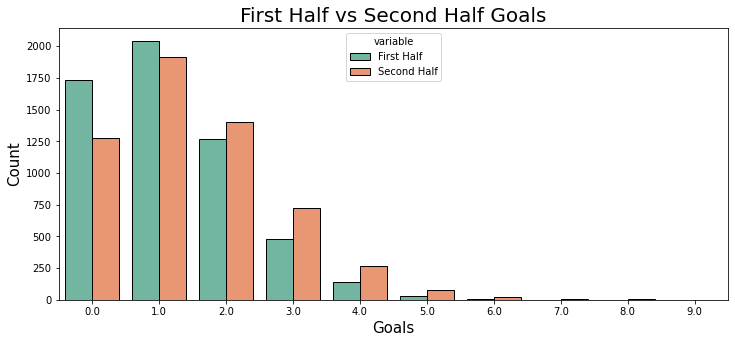

In [132]:
halves = pd.melt(halves)

fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.countplot(x='value', hue='variable', data=halves, palette='Set2', edgecolor='black')
ax.set_xlabel('Goals', fontsize=15);
ax.set_ylabel('Count', fontsize=15);
ax.set_title('First Half vs Second Half Goals', fontsize=20);

plt.savefig('assets/FH-vs-SH-fig2.jpeg', bbox_inches='tight')

- Morever, Poisson Distribution is a simple predictive model that doesn’t allow for numerous factors. Situational factors – such as club circumstances, game status etc. – and subjective evaluation of the change of each team during the transfer window are completely ignored.